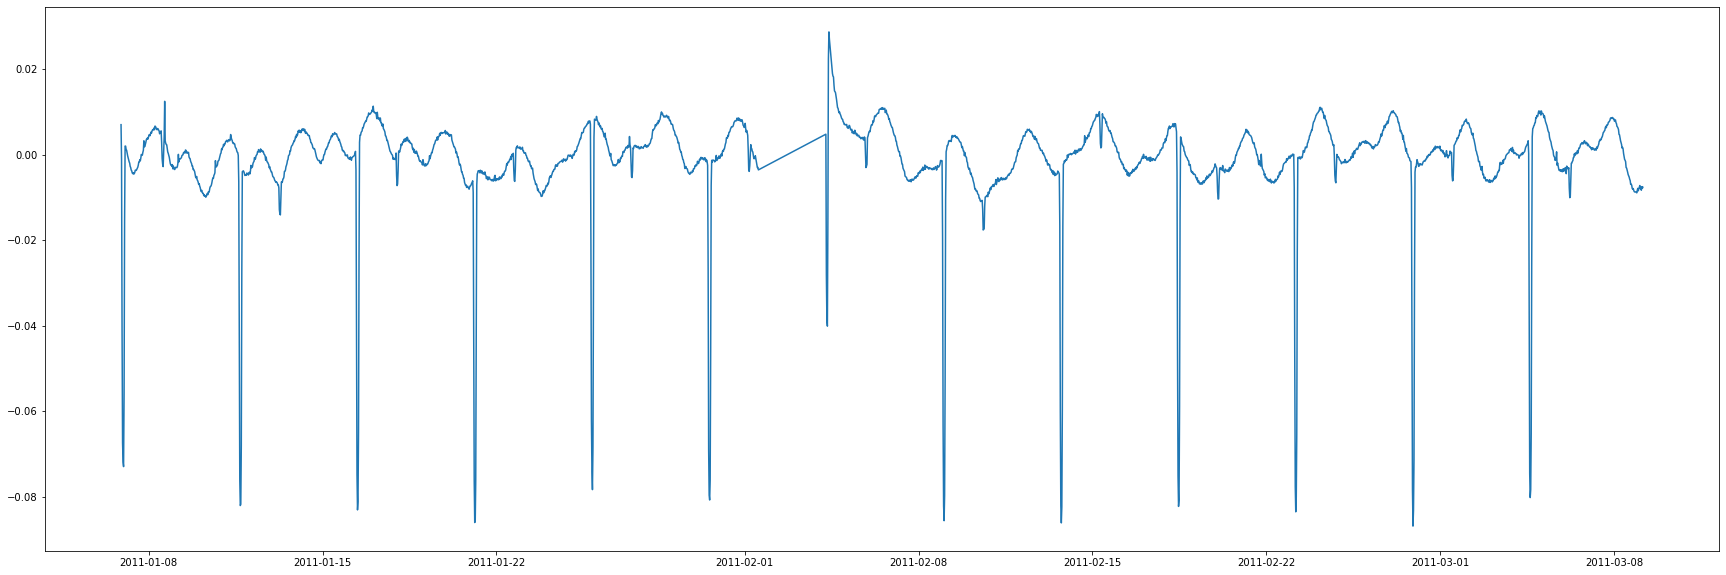

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('data.csv', sep=';')
#change TIME type to float
data['TIME'] = data['TIME'].astype(float)
data["TIME"] = data['TIME'] + 2454833
#Julian to timestamp
data['TIME'] = pd.to_datetime(data['TIME'], unit='D', origin='julian')

#set TIME as index
data.set_index('TIME', inplace=True)
data = data.dropna()
#size of plot (30,10)
plt.figure(figsize=(30,10))
plt.plot(data['LC_INIT'])
plt.show()

## First analyze of the dataset

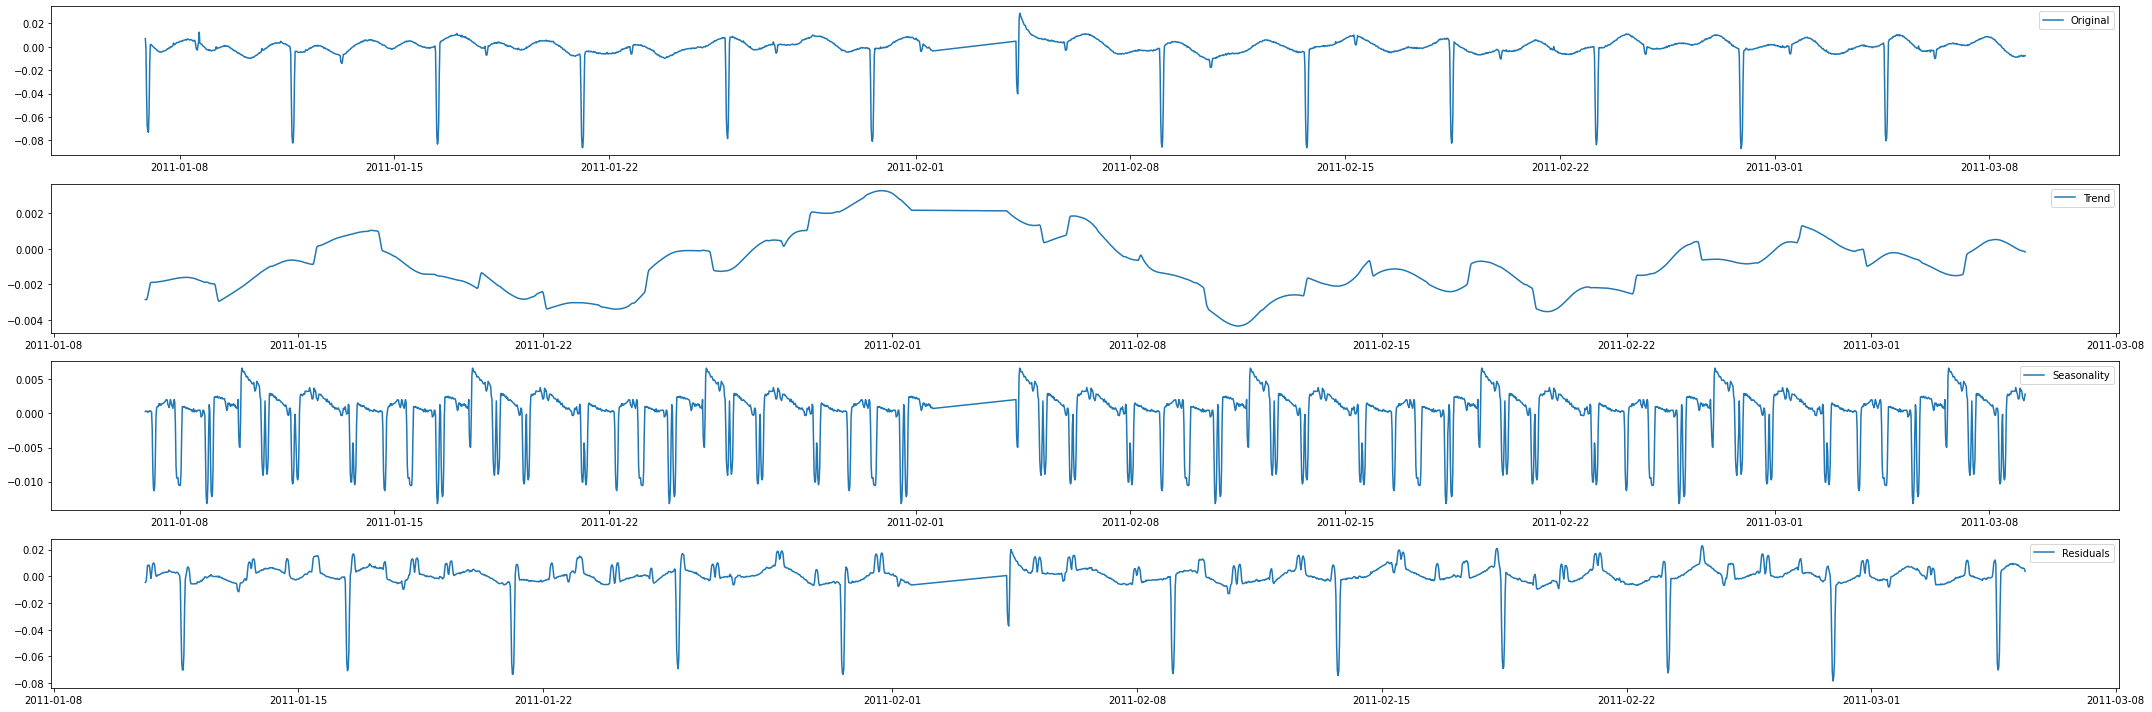

/Users/zekarim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


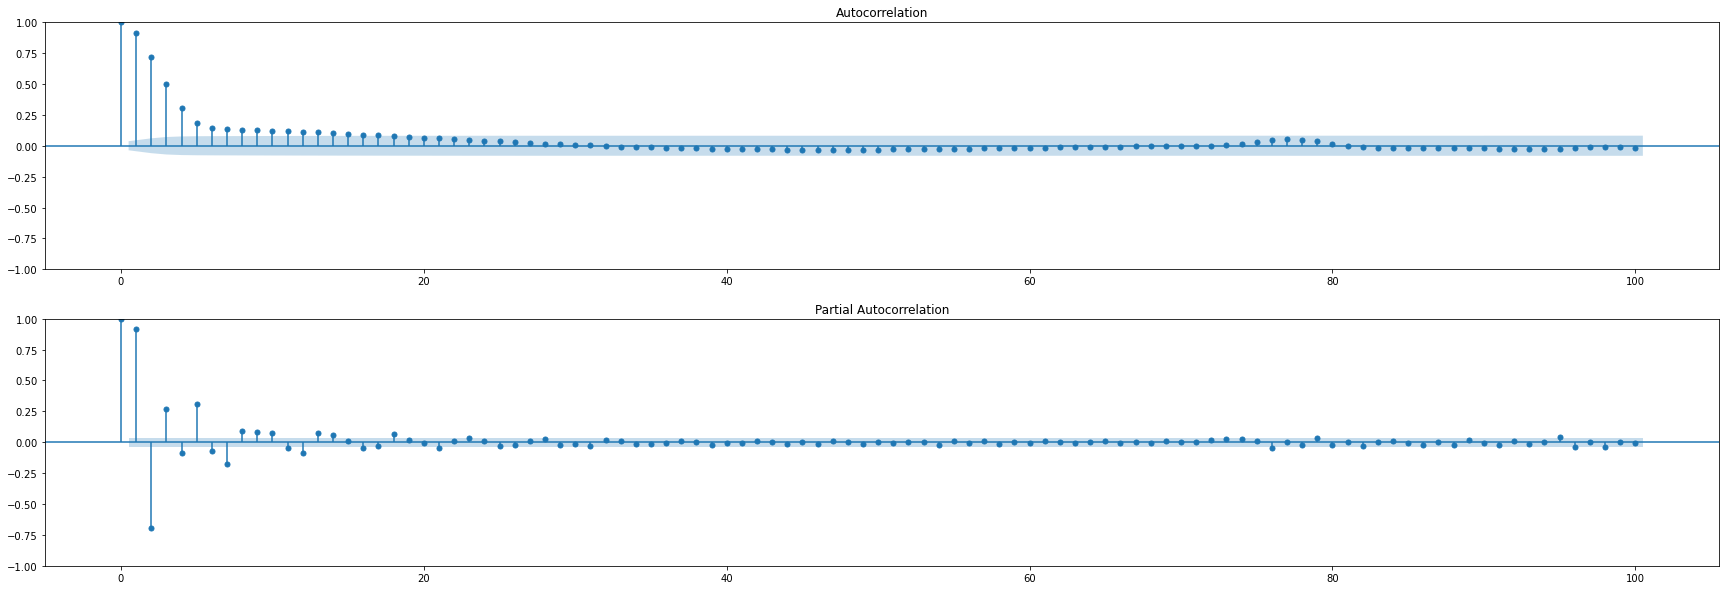

In [2]:
#seasonal decompose
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data['LC_INIT'], period=365)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(30,10))
plt.subplot(411)
plt.plot(data['LC_INIT'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

#ACF and PACF plots:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30,10))
plot_acf(data['LC_INIT'], lags=100, ax=ax1)
plot_pacf(data['LC_INIT'], lags=100, ax=ax2)
plt.show()

## ADF Tests

We can concluse that the dataset is stationnary

In [35]:
from statsmodels.tsa.stattools import adfuller
stationarityTest = adfuller(data, autolag='AIC')
adf, pvalue, usedlag, nobs, critical_values, icbest = stationarityTest

print('ADF Statistic: %f' % adf)
print("P-value: %s" % pvalue)
print("Critical Values: ", critical_values)

print("Is the time series stationary? ", pvalue < 0.05)

ADF Statistic: -9.269339
P-value: 1.3399457782455633e-15
Critical Values:  {'1%': -3.43267762427534, '5%': -2.862568382202542, '10%': -2.567317439165414}
Is the time series stationary?  True
LC_INIT   -0.001044
dtype: float64


## AR Model

Test RMSE: 0.007


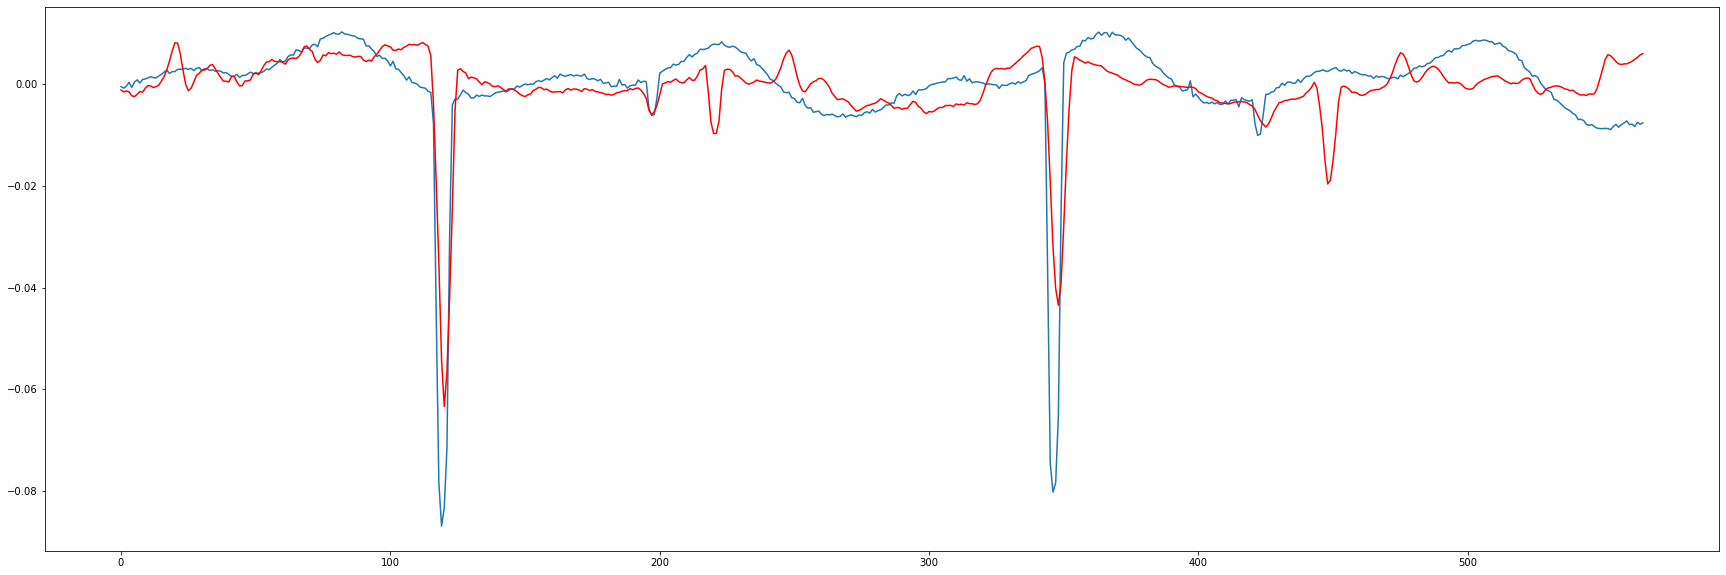

In [47]:
#AR model
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt

X = data['LC_INIT'].values
#split data into train and test 80%
train, test = X[1:len(X)-int(len(X)*0.2)], X[len(X)-int(len(X)*0.2):]

#train autoregression
model = AutoReg(train, lags=365)
model_fit = model.fit()

#make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
error = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % error)

#plot results
plt.figure(figsize=(30,10))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()



## RNN

2022-12-09 20:56:55.571496: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-09 20:56:56.218614: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
1898/1898 - 5s - loss: 0.0112
Epoch 2/100
1898/1898 - 2s - loss: 0.0104
Epoch 3/100
1898/1898 - 2s - loss: 0.0088
Epoch 4/100
1898/1898 - 3s - loss: 0.0063
Epoch 5/100
1898/1898 - 2s - loss: 0.0058
Epoch 6/100
1898/1898 - 2s - loss: 0.0052
Epoch 7/100
1898/1898 - 2s - loss: 0.0048
Epoch 8/100
1898/1898 - 2s - loss: 0.0048
Epoch 9/100
1898/1898 - 3s - loss: 0.0042
Epoch 10/100
1898/1898 - 2s - loss: 0.0040
Epoch 11/100
1898/1898 - 2s - loss: 0.0041
Epoch 12/100
1898/1898 - 2s - loss: 0.0040
Epoch 13/100
1898/1898 - 2s - loss: 0.0034
Epoch 14/100
1898/1898 - 2s - loss: 0.0032
Epoch 15/100
1898/1898 - 2s - loss: 0.0033
Epoch 16/100
1898/1898 - 2s - loss: 0.0038
Epoch 17/100
1898/1898 - 2s - loss: 0.0031
Epoch 18/100
1898/1898 - 2s - loss: 0.0032
Epoch 19/100
1898/1898 - 2s - loss: 0.0032
Epoch 20/100
1898/1898 - 2s - loss: 0.0030
Epoch 21/100
1898/1898 - 2s - loss: 0.0030
Epoch 22/100
1898/1898 - 2s - loss: 0.0030
Epoch 23/100
1898/1898 - 2s - loss: 0.0029
Epoch 24/100
1898/18

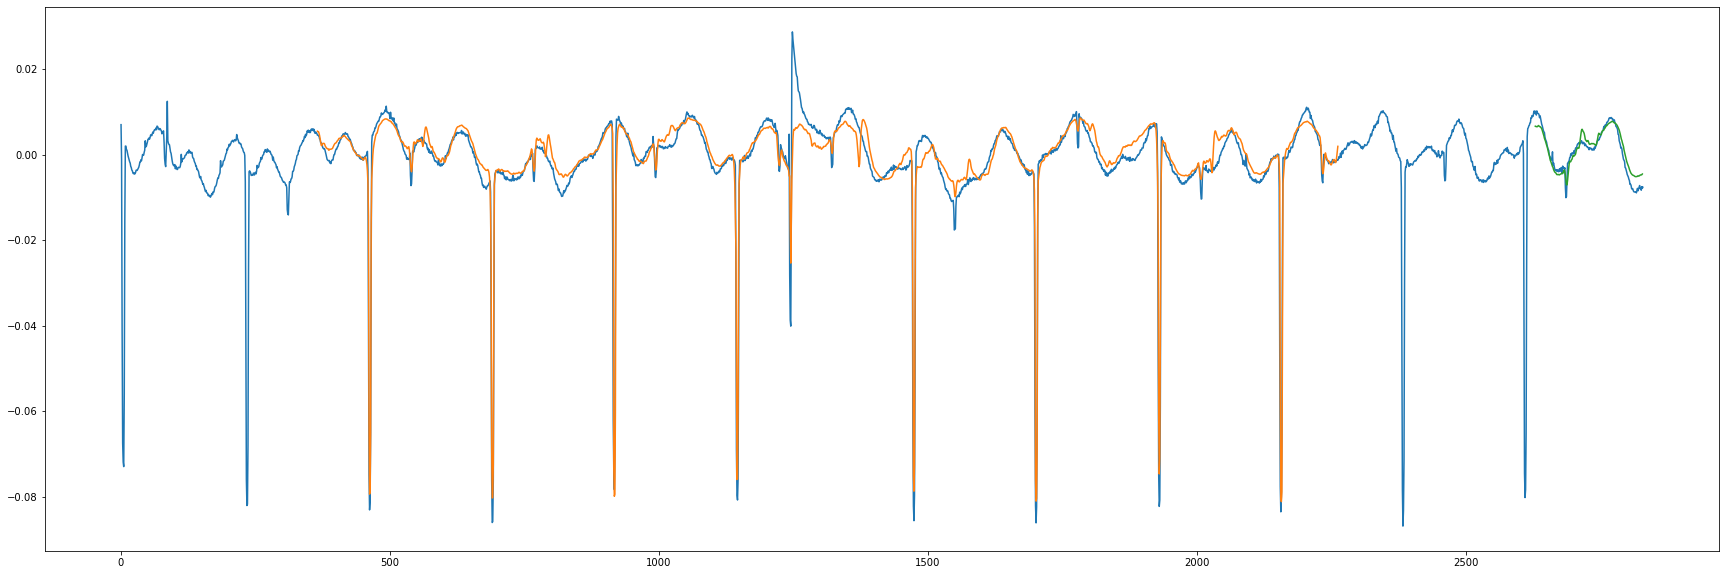

In [3]:
#RNN model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

#normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(data['LC_INIT'].values.reshape(-1,1))

#split into train and test sets
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

#convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

#reshape into X=t and Y=t+1
look_back = 365
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

#reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

#make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

#invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

#calculate root mean squared error
trainScore = sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

#shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

#shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


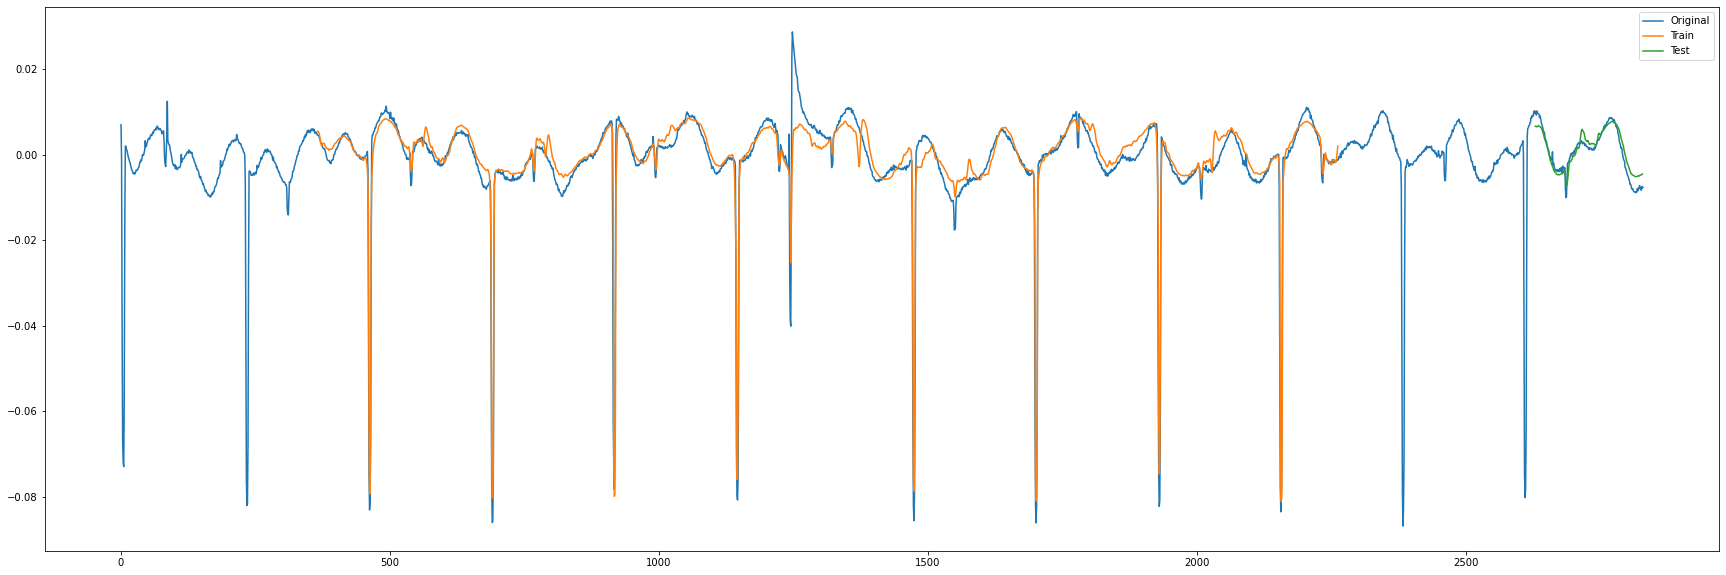

In [4]:
#plot baseline and predictions with labels
plt.figure(figsize=(30,10))
plt.plot(scaler.inverse_transform(dataset), label='Original')
plt.plot(trainPredictPlot, label='Train')
plt.plot(testPredictPlot, label='Test')
plt.legend(loc='best')
plt.show()